## 실습: 퍼셉트론을 이용한 붓꽃 식별
데이터 집합은 'setosa', 'virginica', 'versicolor'라는 세 종류의 붓꽃의 특징 데이터가 50개씩 포함되어 있다.<br>
특징은 꽃받침(sepal)과 꽃잎(petal)의 길이와 폭의 값으로 구성된다.

### 사전 기초 지식
#### <Iris 데이터 구성 예제>
- 꽃받침 길이(Sepal Length), 꽃받침 폭(Sepal Width), 꽃잎 길이(Petal Length), 꽃잎 폭(Petal Width), 꽃의 종류(Iris Species)<br>
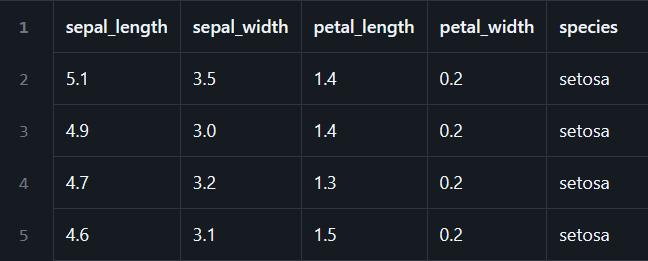<br>

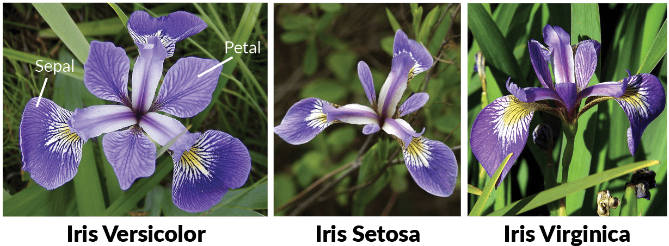

#### <Pandas 모듈 활용하여 Iris 데이터 보기> 
▶ [[Pandas] loc[ ] 로 행, 열 조회하기](https://m.blog.naver.com/wideeyed/221964700554)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

#붓꽃 데이터를 읽어들인다.
iris_data = pd.read_csv('iris.csv', encoding = 'utf-8')

#붓꽃 데이터를 레이블과 입력 데이터로 분리
y = iris_data.loc[:, "variety"] #pandas의 loc로 행열 데이터를 가져온다.
x = iris_data.loc[:, ["sepal.length", "sepal.width", "petal.length", "petal.width", "variety"]]
# print(x)

#학습전용과 테스트 전용 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=True)
print(x_train, y_train)

     sepal.length  sepal.width  petal.length  petal.width     variety
5             5.4          3.9           1.7          0.4      Setosa
140           6.7          3.1           5.6          2.4   Virginica
65            6.7          3.1           4.4          1.4  Versicolor
23            5.1          3.3           1.7          0.5      Setosa
112           6.8          3.0           5.5          2.1   Virginica
..            ...          ...           ...          ...         ...
75            6.6          3.0           4.4          1.4  Versicolor
36            5.5          3.5           1.3          0.2      Setosa
0             5.1          3.5           1.4          0.2      Setosa
135           7.7          3.0           6.1          2.3   Virginica
133           6.3          2.8           5.1          1.5   Virginica

[120 rows x 5 columns] 5          Setosa
140     Virginica
65     Versicolor
23         Setosa
112     Virginica
          ...    
75     Versicolor
36        

<span style="color:orange; font-size: 50px; font-weight:bold">1장 주관식 문제 1번</span><br>

### 코드1-1[1] 필요한 패키지 불러오기
- 데이터 시각화를 위해 matplotlib.pyplot을 사용
- 배열 및 수학 계산을 위해 numpy를 사용
- 붓꽃 데이터 집합을 활용하기 위해 sklearn.datasets의 load_iris를 사용

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

### 주관식 문제 1번 데이터 준비 함수 정의하기
- prepare_data의 인자로 N개의 학습표본 수를 받아서 feature 2개의 랜덤한 집합을 생성합니다.
- 클래스 0의 평균 좌표 (1, 2), 클래스 1의 평균 좌표 (2, 1)을 정의하고,
- 각 클래스의 평균 좌표에 난수를 생성하고 더하는 것을 N만큼 반복하여 랜덤한 학습표본 집합을 생성합니다.
- 그리고 출력으로 리스트를 numpy 배열로 변환하여 학습 데이터 X, 레이블 y, ['0', '1']을 반환합니다.

In [3]:
def prepare_data(N):
    # N : 학습표본의 수
    # 클래스 0의 평균 좌표 : (1, 2)
    # 클래스 1의 평균 좌표 : (2, 1)
    C = np.array([[1, 2], [2, 1]])
    X = []
    y = []

    rnd = np.random.default_rng()
    # 각 클래스의 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
    for i in range(N):
        j = rnd.integers(0, 2)
        x = np.array(rnd.normal(loc=0.0, scale=0.2, size=2)) + C[j]
        X.append(x)
        y.append(j)
    return np.array(X), np.array(y), ['0', '1']

### 코드1-1[3] 활성함수 - 단위 계단 함수

In [4]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

### 코드1-1[4] 퍼셉트론 객체를 만들기 위한 클래스 선언하기
- __init__(self, dim, activation): 퍼셉트론 객체를 초기화한다. 연결 가중치 w와 바이어스 b는 정규분포 랜덤 값으로 초기화
- printW(self): 퍼셉트론 객체의 연결 가중치 및 바이어스를 출력한다.
- predict(self, x): 학습된 퍼셉트론 객체가 입력된 표본 배열 x로부터 출력을 계산하여 반환한다.
- fit(self, X, y, N, ephocs, eta=0.01): 주어진 학습표본 집합을 이용하여 퍼셉트론 객체를 훈련한다. X는 특징, y는 레이블을 저장하는 numpy 배열, N은 표본의 수, epochs는 반복 횟수, eta는 학습률이다.

함수에서 처리하는 내용은 다음과 같다.

- 21 ~ 24행: 학습표본이 무작위 순서로 사용되게 섞는다.
- 29 ~ 40행: 지정된 횟수만큼 전체 학습표본에 대해 반복 학습한다.
- 32행: 클래스의 predict 함수를 사용하여 식(1-14)의 출력을 계산한 후 레이블과의 오차 δ를 구한다.   
- 33~34행: 식(1-15)에 따라 연결 가중치 w와 바이어스 b를 업데이트한다.
<img src="%EC%88%98%EC%8B%9D%281-1415%29.png" width=500px alt="수식 1-14, 1-15"></img>

#### Numpy의 랜덤함수
▲ np.random.normal() => 정규분포(normal distribution)를 고려한 랜덤한수의 배열 생성
```Python
np.random.normal(0, 1, (3,3)) # 평균=0, 표준편차=1, 3x3 배열
```

▲ np.random.rand() => 균등분포(uniform distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.rand(3,3) #3x3 배열
```

▲ np.random.randn() => 표준정규분포(standard normal distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.randn(3,3) #3x3 배열
```

In [5]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim #입력층 입력의 수(특징 개수 -> 길이와 폭 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

### 코드1-1[5] 모델 시각화
학습된 신경망의 동작을 시각화하는 함수를 정의한다.
- net: 학습된 퍼셉트론(신경망)
- X, y: 학습표본 집합의 입력 및 출력/특징 및 레이블의 배열
- multi_class: 3개 이상의 클래를 대상으로 분류하는 신경망인 경우 참(Tru)임.
- labels: 산점도를 그릴 클래스 레이블 리스트
- class_id: 클래스의 이름으로 출력할 스트링 리스트
- colors: 클래스를 구분할 색상 리스트
- xlabel, ylabel: x, y축에 표시할 레이블
- legend_loc: 범례를 표시할 위치

함수에서 처리하는 내용은 다음과 같다.
- 3 ~ 14행: 데이터 범위의 격자 좌표의 배열을 구한다.
- 16 ~ 23행: 학습된 퍼셉트론 객체로 3~14행에서 구한 좌표에 대한 출력을 구한다.
- 25 ~ 43행: pyplot을 이용하여 학습표본(큰 점으로 출력함)과 함께 격자 좌표 배열에 대한 신경망의 식별 결과(작은 점으로 출력)의 산점도를 그린다.

In [6]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

### 코드1-1[6] 훈련 데이터 준비하기
prepare_data 함수를 이용하여 150개의 붓꽃 표본에 대한 2차원 특징을 numpy 배열 형태로 X_tr에 저장한다.
- 대상이 'setosa'인지 식별할 수 있게 훈련하기 위해 학습표본이 'setosa'라면 1
- 그렇지 않으면 0을 y_tr에 numpy 배열 형태로 저장한다.

In [99]:
nSamples = 1000
nDim = 2 #꽃잎의 길이와 너비
target = 'setosa' #식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(1000)

### 코드1-1[7] 퍼셉트론 객체 생성 및 학습
활성함수를 단위 계단 함수로 설정하여 2차원 입력으로 구성되는 퍼셉트론 객체를 생성한다.
- 전체 학습표본에 대해 1,000번 반복하여 학습하며, 학습률은 0.01로 지정한다.

#### <epochs 설명>
한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말한다.
- 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태를 의미한다.

▶ 신경망에서 사용되는 역전파 알고리즘(backpropagation algorithm)은 파라미터를 사용하여 입력부터 출력까지의 각 계층의 weight를 계산하는 과정을 거치는 순방향 패스(forward pass)과 forward pass를 반대로 거슬러 올라가며 다시 한 번 계산 과정을 거처 기존의 weight를 수정하는 역방향 패스(backward pass)로 나뉜다. 
- 이 전체 데이터 셋에 대해 해당 과정(forward pass + backward pass)이 완료되면 한 번의 epoch가 진행됐다고 볼 수 있다.
- 따라서 epochs = 1000 이라면 전체 데이터를 1000번 사용해서 학습을 거치는 것이다.

In [101]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 = -2.719  w2 = -0.638  b =  0.443
Epochs =    1    Loss =  0.01800  w1 = -0.116  w2 = -0.664  b =  1.183
Epochs =    2    Loss =  0.01000  w1 = -0.063  w2 = -0.716  b =  1.153
Epochs =    3    Loss =  0.00600  w1 = -0.022  w2 = -0.731  b =  1.143
Epochs =    4    Loss =  0.00700  w1 = -0.011  w2 = -0.759  b =  1.123
Epochs =    5    Loss =  0.00500  w1 =  0.010  w2 = -0.772  b =  1.113
Epochs =    6    Loss =  0.00300  w1 =  0.036  w2 = -0.770  b =  1.113
Epochs =    7    Loss =  0.00400  w1 =  0.045  w2 = -0.782  b =  1.103
Epochs =    8    Loss =  0.00400  w1 =  0.053  w2 = -0.795  b =  1.093
Epochs =    9    Loss =  0.00400  w1 =  0.062  w2 = -0.808  b =  1.083
Epochs =   10    Loss =  0.00300  w1 =  0.082  w2 = -0.805  b =  1.083
Epochs =  100    Loss =  0.00000  w1 =  0.296  w2 = -0.907  b =  0.933
Epochs =  200    Loss =  0.00000  w1 =  0.296  w2 = -0.907  b =  0.933
Epochs =  300    Loss =  0.00000  w1 =  0.296  w2 = -0.907  b =  0.933
Epochs =  400    Loss =  0.000

### 코드1-1[8] 특징 공간 결정 영역 시각화
붓꽃 데이터 집합에서 꽃잎 길이 및 폭의 최댓값과 최솟값 범위의 영역이 학습된 퍼셉트론에 의해 어떻게 분할되는지 그래프로 보여준다.

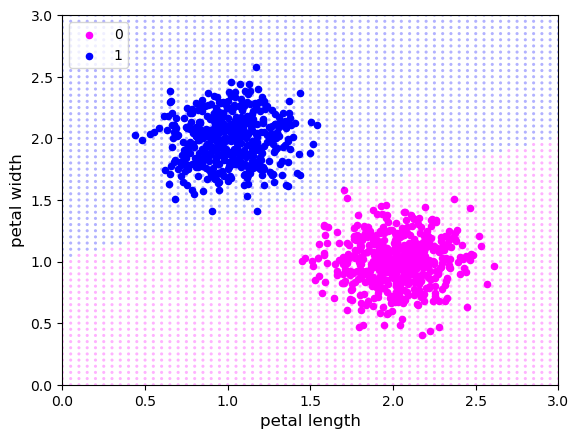

In [102]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'petal length',
          ylabel = 'petal width',
          legend_loc = 'upper left')

학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.

<span style="color:orange; font-size: 30px; font-weight:bold">주관식 문제 1번 실습 결과 고찰</span><br>
- 1번 문제의 학습 데이터는 학습표본의 수를 정하고 있지 않으며, 본 학생은 1000개로 정의하였다.
- 또한 클래스 0, 1 이진분류를 사용하였고 각 클래스의 평균 좌표를 정의하였다.
- 또한 무작위 값을 생성할 학습 데이터는 평균 좌표 + (평균 0, 표준편차 0.2)를 정의하였다.
### 현재 이 모델은 이진 로지스틱 회귀이며 원래는 붓꽃 종류의 이진 분류를 위한 모델이었으나, 교과서에 있는 실습 1번 문제의 prepare_data 함수로 평균 좌표를 중심으로 난수를 생성하였고 학습 데이터 표본 수는 1000개를 사용하였다. 학습 표본은 무작위로 섞었고 가중치 및 바이어스 초깃값은 무작위 수를 이용하고 있다.
### 이 모델은 Epochs가 1000으로 설정되어 있으나 가중치 출력 화면에서도 볼 수 있듯이 Epoch 100 이내에 Loss가 거의 0으로 수렴하여 가중치 값들이 고정되었으므로 보통 100 Epoch 내로 충분한 최적화가 가능해 보인다.
### 그리고 표본 수가 적을 때의 결정경계는 분류에 오차가 나지는 않으나, 한쪽 클래스의 마진이 넓고 학습때마다 위치가 바뀌는 등 불안정하였다. 표본 수를 1000개로 대폭 늘린 경우에는 결정경계가 안정적으로 형성되며 학습 데이터의 분류가 1~2개 빼고는 대부분 일치하는 것으로 확인되었다.
### 시각화는 좌표 평면에 클래스를 0과 1, 핑크와 파랑으로 분류하고 큰 점들은 학습 데이터, 격자 무늬의 작은 점들은 예측값으로 색깔의 경계를 통해 결정경계가 생성되도록 하였다.

<span style="color:orange; font-size: 50px; font-weight:bold">1장 주관식 문제 2번</span><br>

### 코드1-1[1] 필요한 패키지 불러오기
- 데이터 시각화를 위해 matplotlib.pyplot을 사용
- 배열 및 수학 계산을 위해 numpy를 사용
- 붓꽃 데이터 집합을 활용하기 위해 sklearn.datasets의 load_iris를 사용

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

### 주관식 문제 1번 데이터 준비 함수 정의하기
- prepare_data의 인자로 N개의 학습표본 수를 받아서 feature 2개의 랜덤한 집합을 생성합니다.
- 클래스 0의 평균 좌표 (1, 2), 클래스 1의 평균 좌표 (2, 1)을 정의하고,
- 각 클래스의 평균 좌표에 난수를 생성하고 더하는 것을 N만큼 반복하여 랜덤한 학습표본 집합을 생성합니다.
- 그리고 출력으로 리스트를 numpy 배열로 변환하여 학습 데이터 X, 레이블 y, ['0', '1']을 반환합니다.

In [110]:
def prepare_data(N):
    # N : 학습표본의 수
    # 클래스 0의 평균 좌표 : (1, 2), (2, 1)
    # 클래스 1의 평균 좌표 : (1, 1), (2, 2)
    C = np.array([[1, 2], [2, 1], [1, 1], [2, 2]])
    X = []
    y = []

    rnd = np.random.default_rng()
    # 각 클래스의 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
    for i in range(N):
        j = rnd.integers(0, 4)
        x = np.array(rnd.normal(loc=0.0, scale=0.2, size=2)) + C[j]
        X.append(x)
        y.append(j // 2)
    return np.array(X), np.array(y), ['0', '1']

### 코드1-1[3] 활성함수 - 단위 계단 함수

In [111]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

### 코드1-1[4] 퍼셉트론 객체를 만들기 위한 클래스 선언하기
- __init__(self, dim, activation): 퍼셉트론 객체를 초기화한다. 연결 가중치 w와 바이어스 b는 정규분포 랜덤 값으로 초기화
- printW(self): 퍼셉트론 객체의 연결 가중치 및 바이어스를 출력한다.
- predict(self, x): 학습된 퍼셉트론 객체가 입력된 표본 배열 x로부터 출력을 계산하여 반환한다.
- fit(self, X, y, N, ephocs, eta=0.01): 주어진 학습표본 집합을 이용하여 퍼셉트론 객체를 훈련한다. X는 특징, y는 레이블을 저장하는 numpy 배열, N은 표본의 수, epochs는 반복 횟수, eta는 학습률이다.

함수에서 처리하는 내용은 다음과 같다.

- 21 ~ 24행: 학습표본이 무작위 순서로 사용되게 섞는다.
- 29 ~ 40행: 지정된 횟수만큼 전체 학습표본에 대해 반복 학습한다.
- 32행: 클래스의 predict 함수를 사용하여 식(1-14)의 출력을 계산한 후 레이블과의 오차 δ를 구한다.   
- 33~34행: 식(1-15)에 따라 연결 가중치 w와 바이어스 b를 업데이트한다.
<img src="%EC%88%98%EC%8B%9D%281-1415%29.png" width=500px alt="수식 1-14, 1-15"></img>

#### Numpy의 랜덤함수
▲ np.random.normal() => 정규분포(normal distribution)를 고려한 랜덤한수의 배열 생성
```Python
np.random.normal(0, 1, (3,3)) # 평균=0, 표준편차=1, 3x3 배열
```

▲ np.random.rand() => 균등분포(uniform distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.rand(3,3) #3x3 배열
```

▲ np.random.randn() => 표준정규분포(standard normal distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.randn(3,3) #3x3 배열
```

In [112]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim #입력층 입력의 수(특징 개수 -> 길이와 폭 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

### 코드1-1[5] 모델 시각화
학습된 신경망의 동작을 시각화하는 함수를 정의한다.
- net: 학습된 퍼셉트론(신경망)
- X, y: 학습표본 집합의 입력 및 출력/특징 및 레이블의 배열
- multi_class: 3개 이상의 클래를 대상으로 분류하는 신경망인 경우 참(Tru)임.
- labels: 산점도를 그릴 클래스 레이블 리스트
- class_id: 클래스의 이름으로 출력할 스트링 리스트
- colors: 클래스를 구분할 색상 리스트
- xlabel, ylabel: x, y축에 표시할 레이블
- legend_loc: 범례를 표시할 위치

함수에서 처리하는 내용은 다음과 같다.
- 3 ~ 14행: 데이터 범위의 격자 좌표의 배열을 구한다.
- 16 ~ 23행: 학습된 퍼셉트론 객체로 3~14행에서 구한 좌표에 대한 출력을 구한다.
- 25 ~ 43행: pyplot을 이용하여 학습표본(큰 점으로 출력함)과 함께 격자 좌표 배열에 대한 신경망의 식별 결과(작은 점으로 출력)의 산점도를 그린다.

In [113]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

### 코드1-1[6] 훈련 데이터 준비하기
prepare_data 함수를 이용하여 150개의 붓꽃 표본에 대한 2차원 특징을 numpy 배열 형태로 X_tr에 저장한다.
- 대상이 'setosa'인지 식별할 수 있게 훈련하기 위해 학습표본이 'setosa'라면 1
- 그렇지 않으면 0을 y_tr에 numpy 배열 형태로 저장한다.

In [114]:
nSamples = 1000
nDim = 2 #꽃잎의 길이와 너비
target = 'setosa' #식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(1000)

### 코드1-1[7] 퍼셉트론 객체 생성 및 학습
활성함수를 단위 계단 함수로 설정하여 2차원 입력으로 구성되는 퍼셉트론 객체를 생성한다.
- 전체 학습표본에 대해 1,000번 반복하여 학습하며, 학습률은 0.01로 지정한다.

#### <epochs 설명>
한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말한다.
- 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태를 의미한다.

▶ 신경망에서 사용되는 역전파 알고리즘(backpropagation algorithm)은 파라미터를 사용하여 입력부터 출력까지의 각 계층의 weight를 계산하는 과정을 거치는 순방향 패스(forward pass)과 forward pass를 반대로 거슬러 올라가며 다시 한 번 계산 과정을 거처 기존의 weight를 수정하는 역방향 패스(backward pass)로 나뉜다. 
- 이 전체 데이터 셋에 대해 해당 과정(forward pass + backward pass)이 완료되면 한 번의 epoch가 진행됐다고 볼 수 있다.
- 따라서 epochs = 1000 이라면 전체 데이터를 1000번 사용해서 학습을 거치는 것이다.

In [115]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 =  0.012  w2 =  0.041  b =  1.440
Epochs =    1    Loss =  0.30000  w1 = -0.164  w2 = -0.176  b =  0.450
Epochs =    2    Loss =  0.49700  w1 = -0.014  w2 = -0.026  b =  0.010
Epochs =    3    Loss =  0.49700  w1 = -0.006  w2 = -0.021  b = -0.010
Epochs =    4    Loss =  0.49700  w1 = -0.004  w2 = -0.023  b = -0.010
Epochs =    5    Loss =  0.49700  w1 = -0.004  w2 = -0.022  b = -0.010
Epochs =    6    Loss =  0.49700  w1 = -0.003  w2 = -0.008  b = -0.010
Epochs =    7    Loss =  0.49700  w1 = -0.009  w2 = -0.016  b = -0.010
Epochs =    8    Loss =  0.49700  w1 = -0.005  w2 = -0.021  b = -0.010
Epochs =    9    Loss =  0.49700  w1 = -0.008  w2 = -0.019  b = -0.010
Epochs =   10    Loss =  0.49700  w1 = -0.006  w2 = -0.021  b = -0.010
Epochs =  100    Loss =  0.49700  w1 = -0.004  w2 = -0.021  b = -0.010
Epochs =  200    Loss =  0.49700  w1 =  0.000  w2 = -0.003  b = -0.000
Epochs =  300    Loss =  0.49700  w1 = -0.001  w2 = -0.017  b =  0.010
Epochs =  400    Loss =  0.496

### 코드1-1[8] 특징 공간 결정 영역 시각화
붓꽃 데이터 집합에서 꽃잎 길이 및 폭의 최댓값과 최솟값 범위의 영역이 학습된 퍼셉트론에 의해 어떻게 분할되는지 그래프로 보여준다.

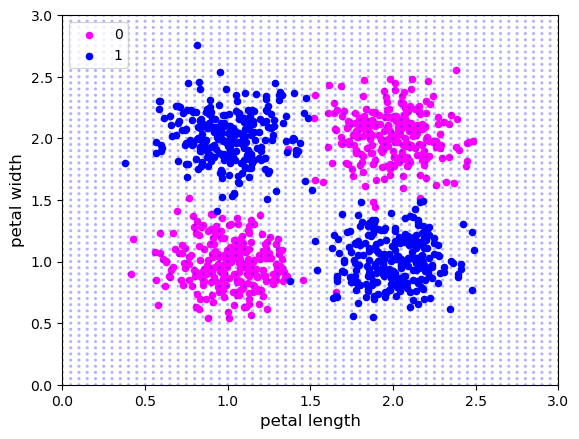

In [116]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'petal length',
          ylabel = 'petal width',
          legend_loc = 'upper left')

학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.

<span style="color:orange; font-size: 30px; font-weight:bold">주관식 문제 2번 실습 결과 고찰</span><br>
- 2번 문제의 학습 데이터는 학습표본의 수를 정하고 있지 않으며, 본 학생은 1000개로 정의하였다.
- 또한 클래스 0, 1 이진분류를 사용하였고 각 클래스의 평균 좌표를 정의하였다.
- 또한 무작위 값을 생성할 학습 데이터는 평균 좌표 + (평균 0, 표준편차 0.2)를 정의하였다.
### 현재 이 모델의 클래스는 2개이나 평균 좌표에 해당하는 4개의 점은 시각화 화면과 같이 상반된 4군데로 산점되어 있다. 따라서 일반적인 이진 분류로는 분리가 불가능함에 따라 예측값은 오분류되어 한쪽으로 쏠린 것으로 확인되었다.
### 또한 가중치 및 바이어스 초깃값은 무작위 수를 이용하고 있고, Epoch 2에서 Loss가 증가하고 이후 Epoch에서도 Loss가 크게 변화하지 않는다. 따라서 가중치 값들이 상당히 불안정하게 변화하는 것으로 관측되었다.
### 시각화는 좌표 평면에 클래스를 0과 1, 핑크와 파랑으로 분류하고 큰 점들은 학습 데이터, 격자 무늬의 작은 점들은 예측값으로 표현하였다.
### 이 문제는 초기 인공지능의 발전 때 해결하지 못해 암흑기를 맞았던 XOR 문제이다. 기존 단층 퍼셉트론으로는 분류가 불가능하지만 은닉층을 추가해 비선형 모델(다층 퍼셉트론)을 만듦으로써 해결할 수 있다.